In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

Running CFL simulation...


<ipython-input-133-8e79ab56ae41>:31: RuntimeWarning: overflow encountered in square
  p = 0.4 * (e - 0.5 * (m**2) / safe_rho)
<ipython-input-133-8e79ab56ae41>:36: RuntimeWarning: overflow encountered in square
  F2 = (m**2) / safe_rho + p
<ipython-input-133-8e79ab56ae41>:37: RuntimeWarning: overflow encountered in multiply
  F3 = (e + p) * u
<ipython-input-133-8e79ab56ae41>:48: RuntimeWarning: invalid value encountered in subtract
  U_new[:, i] = 0.5 * (U[:, i+1] + U[:, i-1]) - 0.5 * dt/dx * (F[:, i+1] - F[:, i-1])
<ipython-input-133-8e79ab56ae41>:28: RuntimeWarning: invalid value encountered in divide
  u = m / safe_rho
<ipython-input-133-8e79ab56ae41>:31: RuntimeWarning: invalid value encountered in divide
  p = 0.4 * (e - 0.5 * (m**2) / safe_rho)
<ipython-input-133-8e79ab56ae41>:36: RuntimeWarning: invalid value encountered in divide
  F2 = (m**2) / safe_rho + p


Running Upwind simulation...


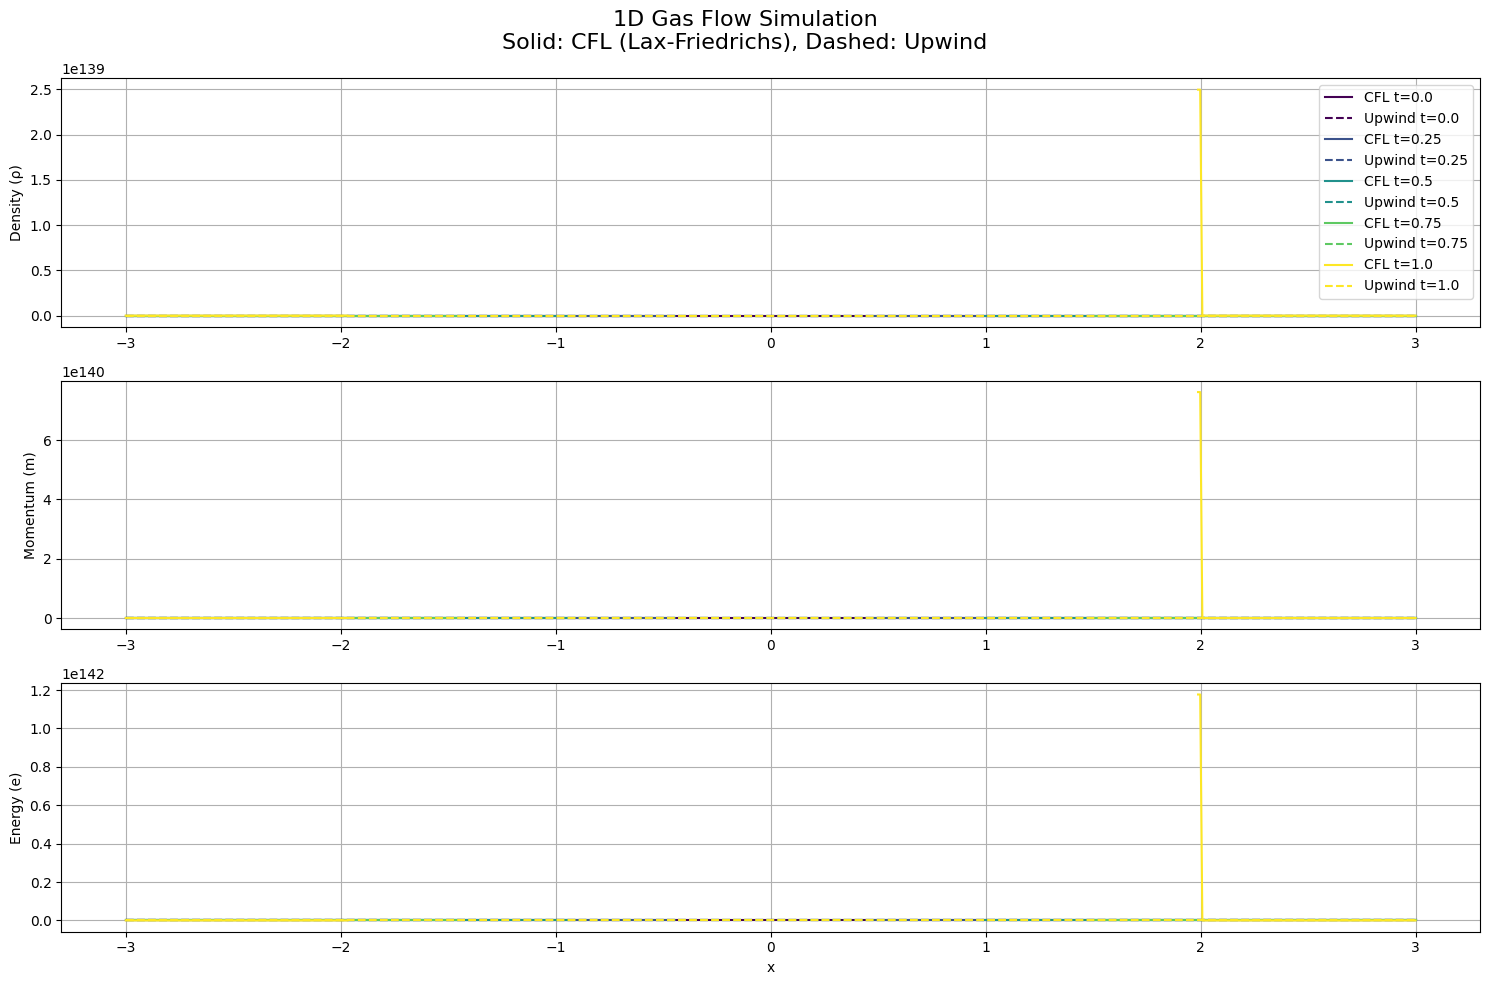

Saving animation...


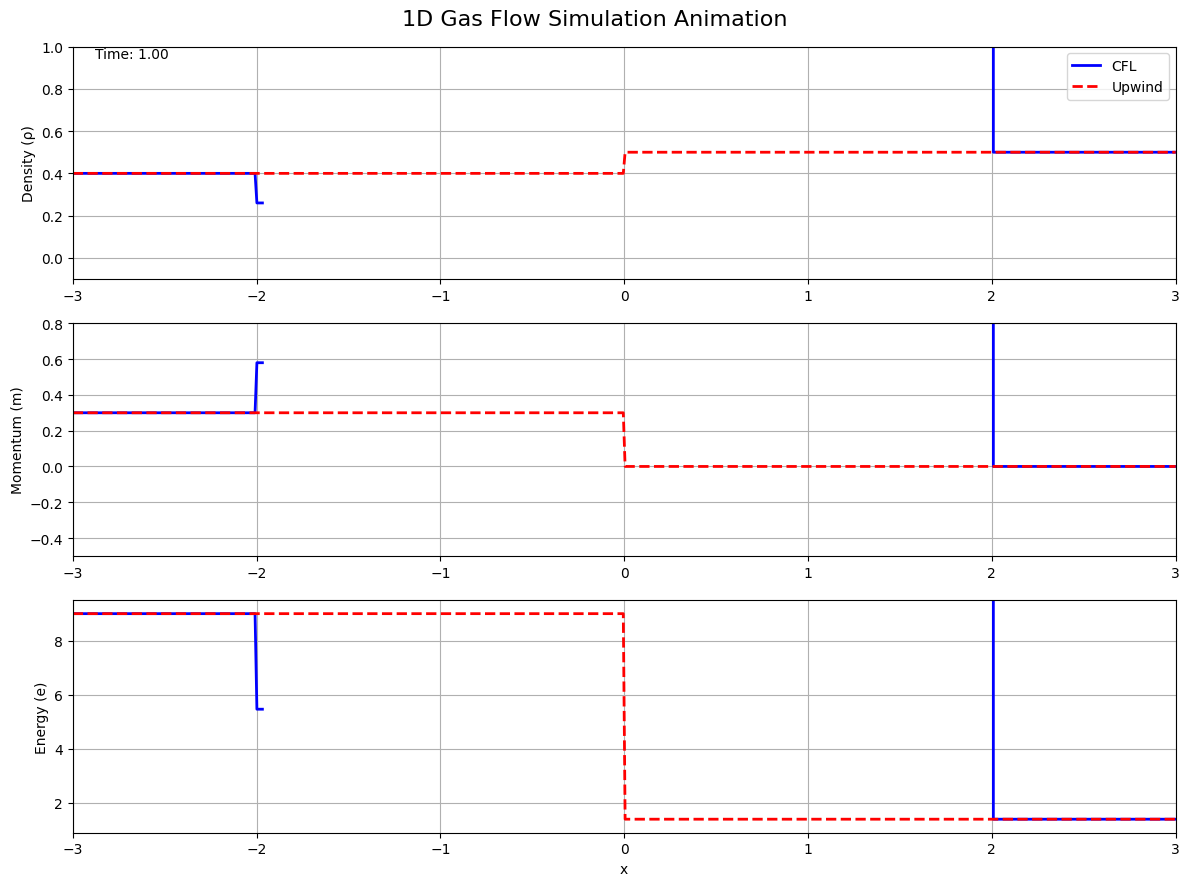

In [ ]:
# Domain and discretization
nx = 600
x = np.linspace(-3, 3, nx)
dx = x[1] - x[0]
gamma = 1.4  # Ideal gas constant
dt = 0.5 * dx  # Time step (CFL condition)
t_final = 1.0
t_save = [0.0, 0.25, 0.5, 0.75, 1.0]

# Initial conditions
U = np.zeros((3, nx))  # [rho, m, e]
U[:, x <= 0] = np.array([[0.4], [0.3], [9]])
U[:, x > 0] = np.array([[0.5], [0.0], [1.4]])

# Helper functions
def compute_flux(U):
    rho, m, e = U

    # Avoid division by zero or very small numbers
    epsilon = 1e-10
    safe_rho = np.maximum(rho, epsilon)

    # Calculate velocity safely
    u = m / safe_rho

    # Calculate pressure safely
    p = 0.4 * (e - 0.5 * (m**2) / safe_rho)
    p = np.maximum(p, epsilon)  # Ensure positive pressure

    # Calculate flux components
    F1 = m
    F2 = (m**2) / safe_rho + p
    F3 = (e + p) * u

    return np.array([F1, F2, F3])

def lax_friedrichs_step(U):
    """Lax-Friedrichs scheme (which is a type of CFL scheme)"""
    F = compute_flux(U)
    U_new = np.copy(U)

    # Interior points
    for i in range(1, nx-1):
        U_new[:, i] = 0.5 * (U[:, i+1] + U[:, i-1]) - 0.5 * dt/dx * (F[:, i+1] - F[:, i-1])

    # Boundary conditions - transmissive
    U_new[:, 0] = U[:, 1]
    U_new[:, -1] = U[:, -2]

    return U_new

def upwind_step(U):
    """Upwind scheme"""
    # Calculate velocity for upwind direction
    rho = U[0]
    m = U[1]

    # Avoid division by zero
    epsilon = 1e-10
    safe_rho = np.maximum(rho, epsilon)
    u = m / safe_rho

    F = compute_flux(U)
    U_new = np.copy(U)

    # Interior points
    for i in range(1, nx-1):
        for j in range(3):
            if u[i] > 0:
                U_new[j, i] = U[j, i] - dt/dx * (F[j, i] - F[j, i-1])
            else:
                U_new[j, i] = U[j, i] - dt/dx * (F[j, i+1] - F[j, i])

    # Boundary conditions - transmissive
    U_new[:, 0] = U[:, 1]
    U_new[:, -1] = U[:, -2]

    return U_new

# Time evolution
def run_simulation(step_func, initial_U):
    """Run simulation and save snapshots at specified times"""
    U_sim = np.copy(initial_U)
    time = 0.0
    snap_dict = {0.0: np.copy(U_sim)}  # Save initial condition

    while time < t_final + 1e-6:
        U_sim = step_func(U_sim)
        time += dt

        # Save snapshots at specified times
        for t in t_save:
            if abs(time - t) < dt/2 and t not in snap_dict:
                snap_dict[t] = np.copy(U_sim)

    return snap_dict

# Run simulations once and store results
print("Running CFL simulation...")
snapshots_cfl = run_simulation(lax_friedrichs_step, U)
print("Running Upwind simulation...")
snapshots_upwind = run_simulation(upwind_step, U)

# Plotting static snapshots
plt.figure(figsize=(15, 10))
quantities = ['Density (ρ)', 'Momentum (m)', 'Energy (e)']
schemes = ["CFL (Lax-Friedrichs)", "Upwind"]
colors = plt.cm.viridis(np.linspace(0, 1, len(t_save)))

for i, quantity in enumerate(quantities):
    plt.subplot(3, 1, i+1)

    for t_idx, t in enumerate(t_save):
        plt.plot(x, snapshots_cfl[t][i], '-', color=colors[t_idx],
                 label=f"CFL t={t}" if i == 0 else "")
        plt.plot(x, snapshots_upwind[t][i], '--', color=colors[t_idx],
                 label=f"Upwind t={t}" if i == 0 else "")

    plt.ylabel(quantity)
    plt.grid(True)
    if i == 0:
        plt.legend(loc='upper right')
    if i == 2:
        plt.xlabel('x')

plt.suptitle('1D Gas Flow Simulation\nSolid: CFL (Lax-Friedrichs), Dashed: Upwind', fontsize=16)
plt.tight_layout()
plt.savefig('gas_flow_snapshots.png', dpi=300)
plt.show()

# Animation using pre-computed results
fig_anim, ax_anim = plt.subplots(3, 1, figsize=(12, 9))
lines_cfl = [ax.plot([], [], 'b-', lw=2, label='CFL' if i==0 else "")[0]
             for i, ax in enumerate(ax_anim)]
lines_upwind = [ax.plot([], [], 'r--', lw=2, label='Upwind' if i==0 else "")[0]
                for i, ax in enumerate(ax_anim)]

# Set up plot details
for i, ax in enumerate(ax_anim):
    ax.set_xlim(-3, 3)

    # Calculate appropriate y-limits for all snapshots
    cfl_min = min([snap[i].min() for snap in snapshots_cfl.values()])
    cfl_max = max([snap[i].max() for snap in snapshots_cfl.values()])
    upwind_min = min([snap[i].min() for snap in snapshots_upwind.values()])
    upwind_max = max([snap[i].max() for snap in snapshots_upwind.values()])

    y_min = min(cfl_min, upwind_min) - 0.5
    y_max = max(cfl_max, upwind_max) + 0.5

    ax.set_ylim(y_min, y_max)
    ax.set_ylabel(quantities[i])
    ax.grid(True)
    if i == 0:
        ax.legend(loc='upper right')
    if i == 2:
        ax.set_xlabel('x')

# Time display text
time_text = ax_anim[0].text(0.02, 0.95, '', transform=ax_anim[0].transAxes)

def init_animation():
    """Initialize animation"""
    for line in lines_cfl + lines_upwind:
        line.set_data([], [])
    time_text.set_text('')
    return lines_cfl + lines_upwind + [time_text]

def animate(frame):
    """Update animation for each frame"""
    # Use predetermined snapshots times for smooth animation
    t_values = sorted(snapshots_cfl.keys())
    if frame < len(t_values):
        t = t_values[frame]

        # Get data for this time
        U_cfl = snapshots_cfl[t]
        U_upwind = snapshots_upwind[t]

        # Update lines
        for i in range(3):
            lines_cfl[i].set_data(x, U_cfl[i])
            lines_upwind[i].set_data(x, U_upwind[i])

        # Update time text
        time_text.set_text(f'Time: {t:.2f}')

    return lines_cfl + lines_upwind + [time_text]

# Create animation - using only saved snapshots to avoid interpolation issues
ani = animation.FuncAnimation(fig_anim, animate, init_func=init_animation,
                              frames=len(t_save), interval=1000, blit=True)

# Save animation
print("Saving animation...")
try:
    ani.save('gas_flow_animation.mp4', writer='ffmpeg', fps=1)
except Exception as e:
    print(f"Could not save animation: {e}")
    print("Continuing with display only...")

plt.suptitle('1D Gas Flow Simulation Animation', fontsize=16)
plt.tight_layout()
plt.show()

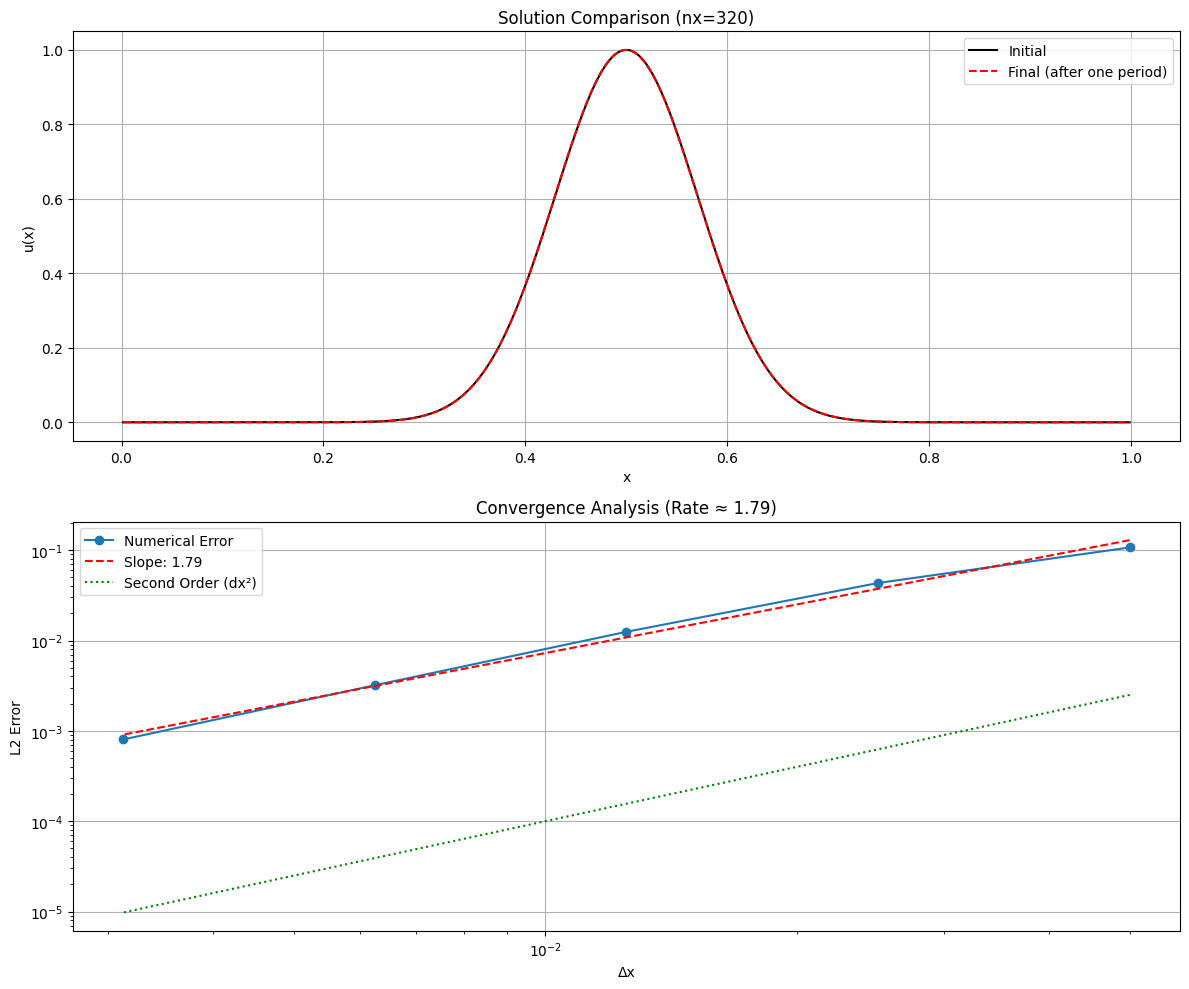


Convergence Analysis Results:
--------------------------------------------------
Grid Size  Δx              L2 Error       
--------------------------------------------------
20         5.000000e-02    1.070849e-01   
40         2.500000e-02    4.330743e-02   
80         1.250000e-02    1.248238e-02   
160        6.250000e-03    3.198927e-03   
320        3.125000e-03    8.027662e-04   
--------------------------------------------------
Estimated convergence rate: 1.7878
Expected convergence rate: 2.0000
--------------------------------------------------


In [ ]:
def initial_condition(x):
    """Gaussian initial condition"""
    return np.exp(-((x - 0.5)**2) / (0.1**2))

def lax_wendroff_step(u, dx, dt, a):
    """
    Perform one step of the Lax-Wendroff method for the advection equation u_t + a*u_x = 0

    Parameters:
    u: current solution
    dx: spatial step size
    dt: time step
    a: advection speed
    """
    n = len(u)
    u_new = np.zeros_like(u)

    # Compute the Courant number
    C = a * dt / dx

    # Lax-Wendroff update
    for i in range(n):
        i_minus_1 = (i - 1) % n  # Periodic boundary
        i_plus_1 = (i + 1) % n   # Periodic boundary

        # Lax-Wendroff formula: u_i^{n+1} = u_i^n - C/2 * (u_{i+1}^n - u_{i-1}^n) + C^2/2 * (u_{i+1}^n - 2*u_i^n + u_{i-1}^n)
        u_new[i] = u[i] - C/2 * (u[i_plus_1] - u[i_minus_1]) + (C**2)/2 * (u[i_plus_1] - 2*u[i] + u[i_minus_1])

    return u_new

def l2_norm(u, dx):
    """Calculate the L2 norm of u"""
    return np.sqrt(dx * np.sum(u**2))

def compute_error(u_final, u_initial, dx):
    """Compute the error between final and initial solutions"""
    return l2_norm(u_final - u_initial, dx)

def solve_advection(nx, courant_number=0.8, a=1.0):
    """
    Solve the advection equation using Lax-Wendroff method

    Parameters:
    nx: number of grid points
    courant_number: CFL number (dt/dx)
    a: advection speed

    Returns:
    error: L2 norm of the error after one period
    """
    # Set up the grid
    dx = 1.0 / nx
    x = np.linspace(dx/2, 1-dx/2, nx)  # Cell-centered grid

    # Set up time step based on Courant number
    dt = courant_number * dx / a

    # Period of the domain for advection speed a
    T = 1.0 / a

    # Initial condition
    u = initial_condition(x)
    u_initial = u.copy()

    # Time stepping
    t = 0
    while t < T:
        # Check if we need to adjust the last time step
        if t + dt > T:
            dt = T - t

        # Update solution
        u = lax_wendroff_step(u, dx, dt, a)

        # Update time
        t += dt

    # Compute error
    error = compute_error(u, u_initial, dx)

    return dx, error, x, u, u_initial

# Analyze convergence for multiple resolutions
grid_resolutions = [20, 40, 80, 160, 320]
errors = []
dxs = []

# Fixed Courant number for all resolutions
courant_number = 0.8
a = 1.0  # Advection speed

plt.figure(figsize=(12, 10))

# Subplot for solution comparison
plt.subplot(2, 1, 1)
for i, nx in enumerate(grid_resolutions):
    dx, error, x, u_final, u_initial = solve_advection(nx, courant_number, a)

    # Store results for convergence analysis
    dxs.append(dx)
    errors.append(error)

    # Plot the solution for the finest grid
    if nx == grid_resolutions[-1]:
        plt.plot(x, u_initial, 'k-', label='Initial')
        plt.plot(x, u_final, 'r--', label='Final (after one period)')
        plt.legend()
        plt.title(f'Solution Comparison (nx={nx})')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.grid(True)

# Compute and display convergence rate
log_dx = np.log10(np.array(dxs))
log_error = np.log10(np.array(errors))

# Linear fit to estimate convergence rate
slope, intercept = np.polyfit(log_dx, log_error, 1)
fit_line = 10**(slope * log_dx + intercept)

# Subplot for convergence analysis
plt.subplot(2, 1, 2)
plt.loglog(dxs, errors, 'o-', label='Numerical Error')
plt.loglog(dxs, fit_line, 'r--', label=f'Slope: {slope:.2f}')
plt.loglog(dxs, [dx**2 for dx in dxs], 'g:', label='Second Order (dx²)')
plt.legend()
plt.title(f'Convergence Analysis (Rate ≈ {slope:.2f})')
plt.xlabel('Δx')
plt.ylabel('L2 Error')
plt.grid(True)

plt.tight_layout()
plt.savefig('lax_wendroff_convergence.png')
plt.show()

# Print convergence results
print("\nConvergence Analysis Results:")
print("-" * 50)
print(f"{'Grid Size':<10} {'Δx':<15} {'L2 Error':<15}")
print("-" * 50)
for i, nx in enumerate(grid_resolutions):
    print(f"{nx:<10} {dxs[i]:<15.6e} {errors[i]:<15.6e}")
print("-" * 50)
print(f"Estimated convergence rate: {slope:.4f}")
print(f"Expected convergence rate: 2.0000")
print("-" * 50)


Shock Speed Analysis:
--------------------------------------------------------------------------------
Method          Initial Condition    Resolution Shock Speed  Analytical   Error %   
--------------------------------------------------------------------------------
nonconservative u(x<0.5)=2, u(x>=0.5)=1 50         1.3311       1.5000       11.26     
nonconservative u(x<0.5)=2, u(x>=0.5)=1 100        1.3147       1.5000       12.35     
nonconservative u(x<0.5)=2, u(x>=0.5)=1 200        1.3295       1.5000       11.36     
nonconservative u(x<0.5)=1, u(x>=0.5)=2 50         0.6918       1.5000       53.88     
nonconservative u(x<0.5)=1, u(x>=0.5)=2 100        0.9218       1.5000       38.55     
nonconservative u(x<0.5)=1, u(x>=0.5)=2 200        1.0429       1.5000       30.47     
conservative    u(x<0.5)=2, u(x>=0.5)=1 50         1.1873       1.5000       20.84     
conservative    u(x<0.5)=2, u(x>=0.5)=1 100        1.2430       1.5000       17.13     
conservative    u(x<0.5)=2

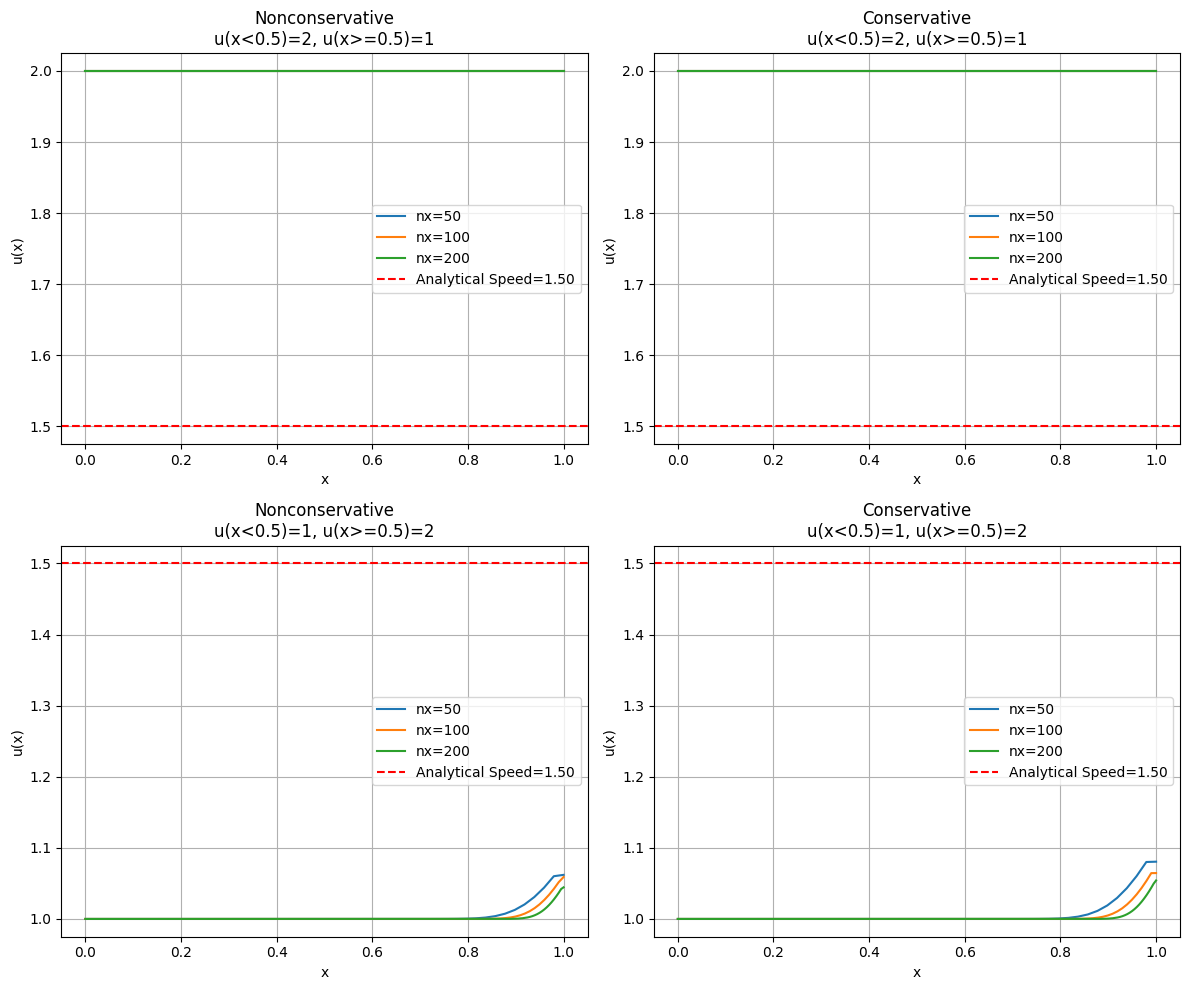

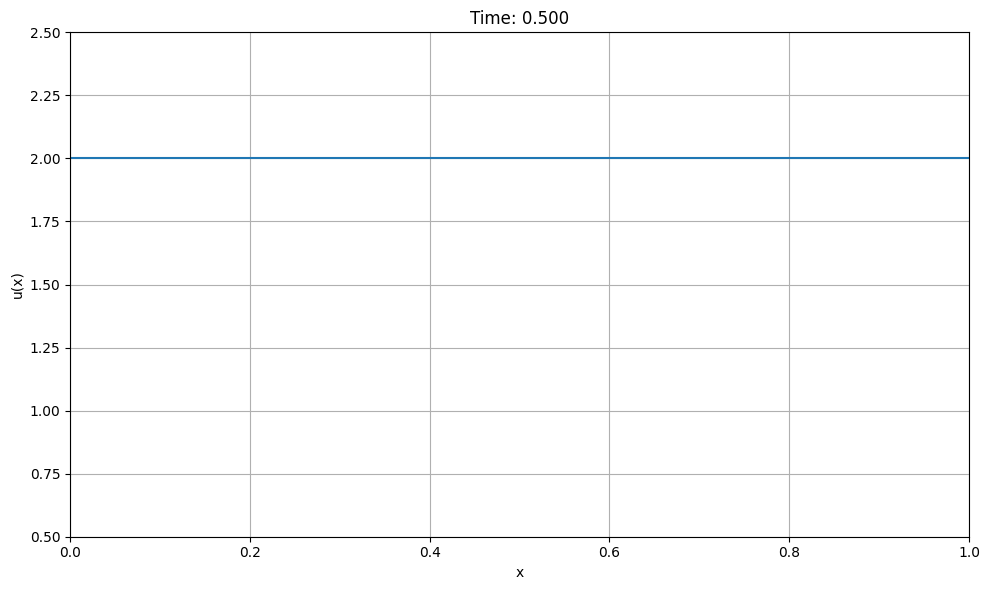

In [ ]:
def initial_condition_1(x):
    """Initial condition: u(x,0) = 2 if x < 0.5; 1 if x >= 0.5"""
    return np.where(x < 0.5, 2.0, 1.0)

def initial_condition_2(x):
    """Initial condition: u(x,0) = 1 if x < 0.5; 2 if x >= 0.5"""
    return np.where(x < 0.5, 1.0, 2.0)

def upwind_nonconservative(u, dx, dt):
    """First-order upwind method for non-conservative form of Burger's equation"""
    n = len(u)
    u_new = np.zeros_like(u)

    # Interior points
    for i in range(1, n-1):
        # Ensure u_i > 0 for upwinding direction
        if u[i] > 0:
            u_new[i] = u[i] - dt/dx * u[i] * (u[i] - u[i-1])
        else:
            u_new[i] = u[i] - dt/dx * u[i] * (u[i+1] - u[i])

    # Boundary conditions (outflow)
    u_new[0] = u[0]
    u_new[-1] = u[-2]  # Outflow: copy from interior

    return u_new

def upwind_conservative(u, dx, dt):
    """First-order upwind method for conservative form of Burger's equation"""
    n = len(u)
    u_new = np.zeros_like(u)

    # Interior points
    for i in range(1, n-1):
        u_new[i] = u[i] - dt/dx * (0.5 * u[i]**2 - 0.5 * u[i-1]**2)

    # Boundary conditions (outflow)
    u_new[0] = u[0]
    u_new[-1] = u[-2]  # Outflow: copy from interior

    return u_new

def simulate_burgers(nx, method, initial_func, cfl_factor=0.8, t_final=0.5):
    """
    Simulate Burger's equation using specified method and initial condition

    Parameters:
    nx: number of grid points
    method: 'nonconservative' or 'conservative'
    initial_func: function for initial condition
    cfl_factor: factor for CFL condition
    t_final: final simulation time

    Returns:
    x: grid points
    solution_history: array of solution at each saved time step
    time_history: array of saved time steps
    """
    # Set up the grid
    x_min, x_max = 0.0, 1.0
    dx = (x_max - x_min) / (nx - 1)
    x = np.linspace(x_min, x_max, nx)

    # Initial condition
    u = initial_func(x)

    # Select method
    if method == 'nonconservative':
        step_func = upwind_nonconservative
    else:  # conservative
        step_func = upwind_conservative

    # Prepare for time-stepping
    t = 0.0
    solution_history = [u.copy()]
    time_history = [t]
    save_interval = 0.02  # Save solution every 0.02 time units
    next_save = save_interval

    while t < t_final:
        # Dynamic time step based on CFL condition
        u_max = np.max(np.abs(u))
        dt = cfl_factor * dx / u_max if u_max > 0 else dx

        # Ensure we don't exceed the final time
        if t + dt > t_final:
            dt = t_final - t

        # Update solution
        u = step_func(u, dx, dt)

        # Update time
        t += dt

        # Save solution at regular intervals
        if t >= next_save or t >= t_final:
            solution_history.append(u.copy())
            time_history.append(t)
            next_save += save_interval

    return x, np.array(solution_history), np.array(time_history)

def detect_shock_position(u, x):
    """
    Detect the position of a shock by finding the maximum gradient

    Parameters:
    u: solution array
    x: grid points

    Returns:
    shock_pos: position of the shock
    """
    # Compute gradients
    gradients = np.abs(np.diff(u))

    # Find position of maximum gradient
    max_grad_idx = np.argmax(gradients)

    # Estimate shock position as midpoint between cells
    shock_pos = 0.5 * (x[max_grad_idx] + x[max_grad_idx + 1])

    return shock_pos

def calculate_shock_speed(shock_positions, times):
    """
    Calculate shock speed from shock positions and times

    Parameters:
    shock_positions: array of shock positions
    times: array of corresponding times

    Returns:
    shock_speed: average shock speed
    """
    # Calculate shock speed using linear regression
    if len(shock_positions) > 1:
        # Use only the middle portion of the simulation to avoid initial transients
        start_idx = len(shock_positions) // 4
        end_idx = 3 * len(shock_positions) // 4

        # Fit a line to the shock positions vs time
        times_subset = times[start_idx:end_idx]
        positions_subset = shock_positions[start_idx:end_idx]

        # Simple linear regression
        slope, _ = np.polyfit(times_subset, positions_subset, 1)
        return slope
    else:
        return None

def analytical_shock_speed(u_left, u_right):
    """
    Calculate analytical shock speed for Burger's equation

    Parameters:
    u_left: value of u to the left of the shock
    u_right: value of u to the right of the shock

    Returns:
    shock_speed: analytical shock speed
    """
    return 0.5 * (u_left + u_right)

def analyze_burger_equation():
    """Analyze different methods for Burger's equation"""
    # Grid resolutions
    resolutions = [50, 100, 200]

    # Methods
    methods = ['nonconservative', 'conservative']

    # Initial conditions
    initial_funcs = [initial_condition_1, initial_condition_2]
    initial_names = ['u(x<0.5)=2, u(x>=0.5)=1', 'u(x<0.5)=1, u(x>=0.5)=2']

    # Create figure
    fig, axes = plt.subplots(len(initial_funcs), len(methods), figsize=(12, 10))

    # Store results for shock speed analysis
    shock_speeds = {method: {f"ic{i+1}": {res: None for res in resolutions}
                            for i in range(len(initial_funcs))}
                   for method in methods}

    for i, initial_func in enumerate(initial_funcs):
        for j, method in enumerate(methods):
            # Analytical shock speeds (if applicable)
            if i == 0:  # Initial condition 1
                u_left, u_right = 2.0, 1.0
                analytical_speed = analytical_shock_speed(u_left, u_right)
            else:  # Initial condition 2
                u_left, u_right = 1.0, 2.0
                analytical_speed = analytical_shock_speed(u_left, u_right)

            # Plot for each resolution
            for nx in resolutions:
                x, solution_history, time_history = simulate_burgers(nx, method, initial_func)

                # Plot the final solution
                axes[i, j].plot(x, solution_history[-1], label=f'nx={nx}')

                # Detect shock positions throughout simulation
                shock_positions = []
                for k in range(len(time_history)):
                    # Skip the first few time steps to let the solution develop
                    if k > len(time_history) // 10:
                        shock_pos = detect_shock_position(solution_history[k], x)
                        shock_positions.append(shock_pos)

                # Calculate shock speed if there are enough time steps
                if len(shock_positions) > 1:
                    times = time_history[len(time_history)//10:]
                    speed = calculate_shock_speed(shock_positions, times)
                    shock_speeds[method][f"ic{i+1}"][nx] = speed

            # Add a horizontal line for the analytical shock speed
            axes[i, j].axhline(y=analytical_speed, color='r', linestyle='--',
                               label=f'Analytical Speed={analytical_speed:.2f}')

            # Set title and labels
            axes[i, j].set_title(f'{method.capitalize()}\n{initial_names[i]}')
            axes[i, j].set_xlabel('x')
            axes[i, j].set_ylabel('u(x)')
            axes[i, j].legend()
            axes[i, j].grid(True)

    plt.tight_layout()
    plt.savefig('burgers_equation_comparison.png')

    # Print shock speed analysis
    print("\nShock Speed Analysis:")
    print("-" * 80)
    print(f"{'Method':<15} {'Initial Condition':<20} {'Resolution':<10} {'Shock Speed':<12} {'Analytical':<12} {'Error %':<10}")
    print("-" * 80)

    for method in methods:
        for i in range(len(initial_funcs)):
            ic_key = f"ic{i+1}"
            if i == 0:
                analytical = analytical_shock_speed(2.0, 1.0)
            else:
                analytical = analytical_shock_speed(1.0, 2.0)

            for nx in resolutions:
                speed = shock_speeds[method][ic_key][nx]
                if speed is not None:
                    error = abs(speed - analytical) / analytical * 100
                    print(f"{method:<15} {initial_names[i]:<20} {nx:<10} {speed:<12.4f} {analytical:<12.4f} {error:<10.2f}")

    print("-" * 80)

    # Create animation for the most interesting case
    # Using high resolution for smoother animation
    nx = 200
    method = 'conservative'
    initial_func = initial_condition_1

    x, solution_history, time_history = simulate_burgers(nx, method, initial_func)

    # Create animation
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot(x, solution_history[0])
    ax.set_ylim(0.5, 2.5)
    ax.set_xlim(0, 1)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x)')
    ax.grid(True)
    title = ax.set_title(f'Time: {time_history[0]:.3f}')

    def update(frame):
        line.set_ydata(solution_history[frame])
        title.set_text(f'Time: {time_history[frame]:.3f}')
        return line, title

    ani = FuncAnimation(fig, update, frames=len(time_history), interval=100, blit=True)

    plt.tight_layout()
    ani.save('burgers_equation_animation.gif', writer='pillow', fps=10)

    return shock_speeds

# Run the analysis
if __name__ == "__main__":
    shock_speeds = analyze_burger_equation()